# Jonathan Halverson
# Tuesday, December 5, 2017
# Speech recognition: "Yes" versus "Nine"

This is a simple demonstration of speech recognition. It works by creating a spectrogram for each word then training a CNN to distinguish between the two words. The CNN approach works better than a fully connected DNN as well as a logistic regression model. This is not a state-of-the-art model but it is a nice illustration of feature engineering and how a CNN can be used. Preprocessing the data would surely help. One thing to do would be to remove the silence before and after the word. One could also use data augmentation to change the rate of speech as well as the the amplitude. Is the spectrogram independent of the spectrogram? Seems like it should be.

In [156]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [157]:
from scipy.io import wavfile

f = 'datasets/speech_commands_v0.01/yes/0a7c2a8d_nohash_0.wav'
f = 'datasets/speech_commands_v0.01/eight/3a70ab7f_nohash_0.wav'
f = 'datasets/speech_commands_v0.01/marvin/4a4e28f1_nohash_0.wav'
f = 'datasets/speech_commands_v0.01/marvin/5a9f7324_nohash_0.wav' # low freq
f = 'datasets/speech_commands_v0.01/marvin/6a861f21_nohash_0.wav' # high freq
sample_rate, data = wavfile.read(f) # 16-bit  PCM  -32768  +32767  int16
times = np.arange(data.size) / float(sample_rate)

How many samples per second are there?

In [158]:
sample_rate

16000

What do the first ten values look like?

In [159]:
data[:10]

array([ 1,  3,  3,  1,  0,  0,  0,  0,  0, -1], dtype=int16)

How many samples are there?

In [160]:
data.size

16000

How many unique values are there?

In [161]:
np.unique(data).size

7259

What are the min, mean and max values?

In [162]:
data.min(), data.mean(), data.max()

(-28099, -0.20075000000000001, 32767)

In [163]:
2**16 - 0.5 * 2**16 # 16-bit  PCM  -32768  +32767  int16

32768.0

Here is the waveform:

(-32768, 32768)

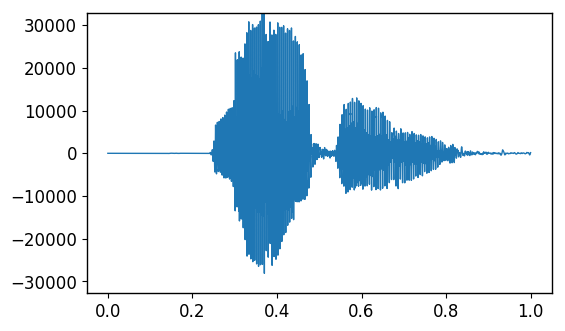

In [164]:
plt.plot(times, data)
plt.ylim(-2**15, 2**15)

(-32768, 32768)

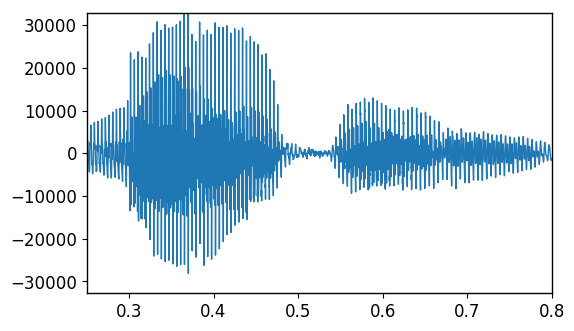

In [165]:
plt.plot(times, data)
plt.xlim(0.25, 0.8)
plt.ylim(-2**15, 2**15)

Here is 1/100 of second in the middle:

(-32768, 32768)

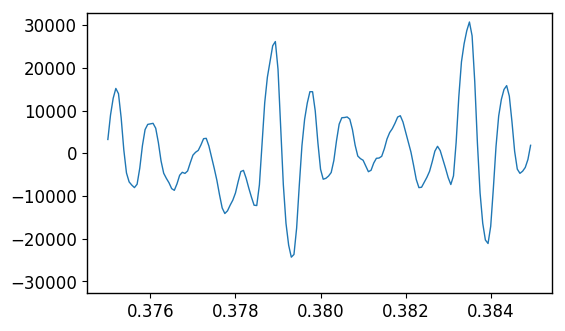

In [166]:
plt.plot(np.arange(6000, 6160) / float(sample_rate), data[6000:6160])
plt.ylim(-2**15, 2**15)

### Let's make a spectrogram manually

The idea is to compute the DFT of the signal over a set of overlapping windows:

In [167]:
N = data.size
freq = np.fft.fftfreq(n=N, d=1.0/sample_rate)
Hn = np.fft.fft(data)

In [168]:
msk = ~(freq < 0.0)

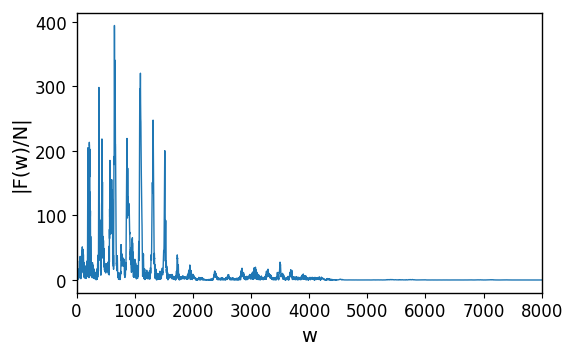

In [169]:
plt.plot(freq[msk], np.absolute(Hn[msk] / N))
plt.xlim(0, 8000)
plt.xlabel('w')
plt.ylabel('|F(w)/N|')

In [170]:
samples_per_chunk = 256
freq = np.fft.fftfreq(n=samples_per_chunk, d=1.0/sample_rate)
ind = np.argwhere(freq > 0.0).flatten()
chunks = data.size / samples_per_chunk
times = np.linspace(0.0, 1.0, num=chunks)

In [171]:
acc = []
for chunk in range(chunks):
     Hn = np.fft.fft(data[chunk * samples_per_chunk:(chunk + 1) * samples_per_chunk])
     Xn = np.absolute(Hn[ind])**2 + np.absolute(Hn[-ind])**2
     acc.append(Xn)

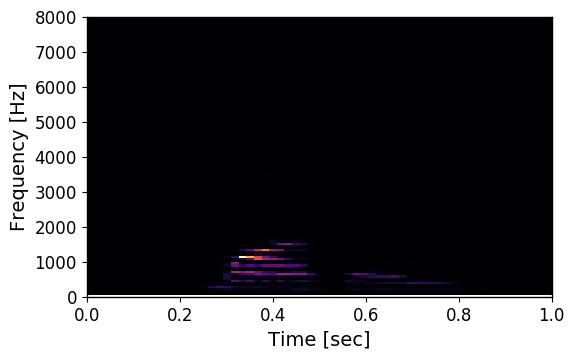

In [172]:
plt.pcolormesh(times, freq[ind], np.array(acc).T, cmap='inferno')
plt.ylim(0, 8e3)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

We could recover the w=8000 Hz values by making the samples_per_chunk value an odd number. Note that usually a spectrogram is made using overlapping windows. Here the windows do not overlap.

### Below we use SciPy to compute the spectrogram:

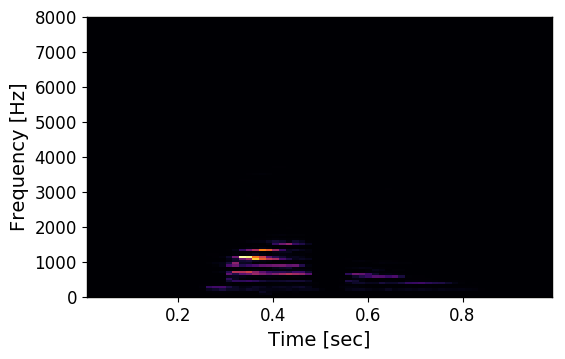

In [173]:
from scipy import signal

sample_rate, samples = wavfile.read(f)
assert sample_rate == 16000
assert samples.size == 16000
frequencies, times, spectrogram = signal.spectrogram(samples, fs=sample_rate, window=('tukey', 0.25), scaling='density')

plt.pcolormesh(times, frequencies, spectrogram, cmap='inferno')
plt.ylim(0, 8e3)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [181]:
np.fft.fftfreq(256, 1.0/sample_rate)[:129]

array([    0. ,    62.5,   125. ,   187.5,   250. ,   312.5,   375. ,
         437.5,   500. ,   562.5,   625. ,   687.5,   750. ,   812.5,
         875. ,   937.5,  1000. ,  1062.5,  1125. ,  1187.5,  1250. ,
        1312.5,  1375. ,  1437.5,  1500. ,  1562.5,  1625. ,  1687.5,
        1750. ,  1812.5,  1875. ,  1937.5,  2000. ,  2062.5,  2125. ,
        2187.5,  2250. ,  2312.5,  2375. ,  2437.5,  2500. ,  2562.5,
        2625. ,  2687.5,  2750. ,  2812.5,  2875. ,  2937.5,  3000. ,
        3062.5,  3125. ,  3187.5,  3250. ,  3312.5,  3375. ,  3437.5,
        3500. ,  3562.5,  3625. ,  3687.5,  3750. ,  3812.5,  3875. ,
        3937.5,  4000. ,  4062.5,  4125. ,  4187.5,  4250. ,  4312.5,
        4375. ,  4437.5,  4500. ,  4562.5,  4625. ,  4687.5,  4750. ,
        4812.5,  4875. ,  4937.5,  5000. ,  5062.5,  5125. ,  5187.5,
        5250. ,  5312.5,  5375. ,  5437.5,  5500. ,  5562.5,  5625. ,
        5687.5,  5750. ,  5812.5,  5875. ,  5937.5,  6000. ,  6062.5,
        6125. ,  618

In [175]:
frequencies

array([    0. ,    62.5,   125. ,   187.5,   250. ,   312.5,   375. ,
         437.5,   500. ,   562.5,   625. ,   687.5,   750. ,   812.5,
         875. ,   937.5,  1000. ,  1062.5,  1125. ,  1187.5,  1250. ,
        1312.5,  1375. ,  1437.5,  1500. ,  1562.5,  1625. ,  1687.5,
        1750. ,  1812.5,  1875. ,  1937.5,  2000. ,  2062.5,  2125. ,
        2187.5,  2250. ,  2312.5,  2375. ,  2437.5,  2500. ,  2562.5,
        2625. ,  2687.5,  2750. ,  2812.5,  2875. ,  2937.5,  3000. ,
        3062.5,  3125. ,  3187.5,  3250. ,  3312.5,  3375. ,  3437.5,
        3500. ,  3562.5,  3625. ,  3687.5,  3750. ,  3812.5,  3875. ,
        3937.5,  4000. ,  4062.5,  4125. ,  4187.5,  4250. ,  4312.5,
        4375. ,  4437.5,  4500. ,  4562.5,  4625. ,  4687.5,  4750. ,
        4812.5,  4875. ,  4937.5,  5000. ,  5062.5,  5125. ,  5187.5,
        5250. ,  5312.5,  5375. ,  5437.5,  5500. ,  5562.5,  5625. ,
        5687.5,  5750. ,  5812.5,  5875. ,  5937.5,  6000. ,  6062.5,
        6125. ,  618

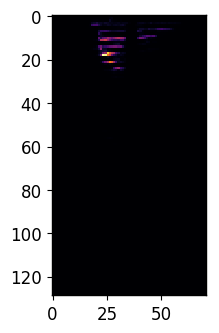

In [176]:
# spectrogram[::-1,] to invert vertically
plt.imshow(spectrogram / spectrogram.max(), cmap='inferno', interpolation='none')

In [177]:
height, width = spectrogram.shape
height, width

(129, 71)

In [178]:
type(spectrogram), spectrogram.dtype

(numpy.ndarray, dtype('float32'))

In [179]:
spectrogram.min(), spectrogram.mean(), spectrogram.max()

(6.7560459e-09, 2645.7983, 654511.19)

### Prepare the data for Tensorflow

In [22]:
import glob

In [23]:
yes = glob.glob('datasets/speech_commands_v0.01/yes/*.wav')
nine = glob.glob('datasets/speech_commands_v0.01/nine/*.wav')

Shuffle the paths and labels:

In [24]:
paths = np.array(yes + nine)
labels = np.append(np.zeros(len(yes), dtype=np.int32), [np.ones(len(nine), dtype=np.int32)])
indices = np.arange(paths.size)
np.random.shuffle(indices)

In [25]:
paths = paths[indices]
labels = labels[indices]

In [26]:
np.bincount(labels)

array([2377, 2364])

Remove samples which are not 1 second long and recorded at 16 kHz:

In [27]:
clean_paths = []
clean_labels = []
for path, label in zip(paths, labels):
     sample_rate, samples = wavfile.read(path)
     if (sample_rate == 16000) and (samples.size == 16000):
          clean_paths.append(path)
          clean_labels.append(label)
paths = np.array(clean_paths)
labels = np.array(clean_labels)

In [28]:
np.bincount(labels)

array([2157, 2174])

Create a train-test split:

In [29]:
train_size = 0.8
thres = int(paths.size * train_size)
train_paths = paths[:thres]
train_labels = labels[:thres]
test_paths = paths[thres:]
test_labels = labels[thres:]

In [30]:
def fetch_batch(sound_paths, sound_labels, batch_size=25):
     indices = np.random.choice(np.arange(sound_paths.size), size=batch_size, replace=False)
     acc = []
     for path in sound_paths[indices]:
          sample_rate, samples = wavfile.read(path)
          frequencies, times, spectrogram = signal.spectrogram(samples, fs=sample_rate)
          acc.append(spectrogram / spectrogram.max()) # scale to [0, 1]
     return np.array(acc), sound_labels[indices]

In [31]:
X_test, y_test = fetch_batch(test_paths, test_labels, batch_size=test_paths.size)
X_test.shape

(867, 129, 71)

In [32]:
np.bincount(y_test)

array([424, 443])

In [33]:
ind_0 = np.argwhere(y_test == 0).flatten()
ind_1 = np.argwhere(y_test == 1).flatten()

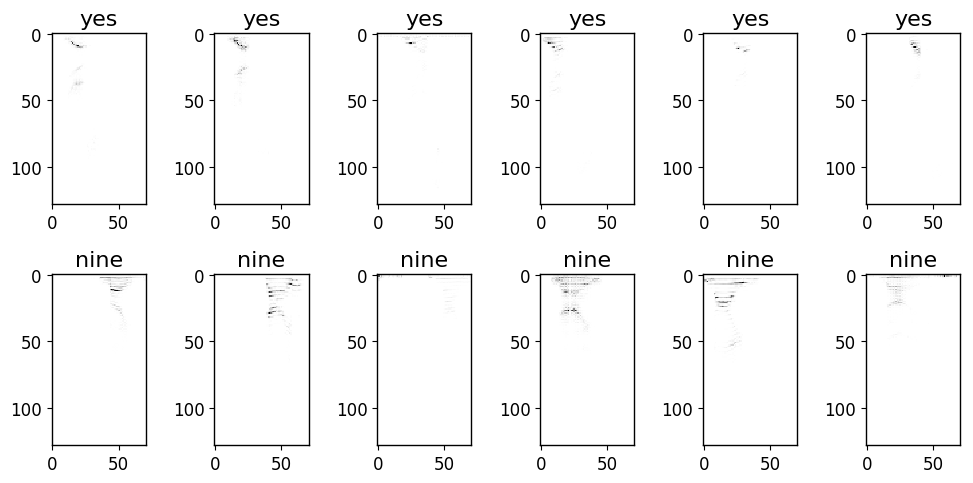

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(10, 5))
for j in range(6):
     ax[0, j].imshow(X_test[ind_0[j]], cmap='binary', interpolation='none')
     ax[0, j].set_title('yes')
for j in range(6):
     ax[1, j].imshow(X_test[ind_1[j]], cmap='binary', interpolation='none')
     ax[1, j].set_title('nine')
fig.tight_layout()

### Check the sigmoid function in TF

In [35]:
import tensorflow as tf

In [36]:
tf.reset_default_graph()

In [37]:
x = tf.constant(np.linspace(-5, 5, num=250))
y = tf.sigmoid(x)

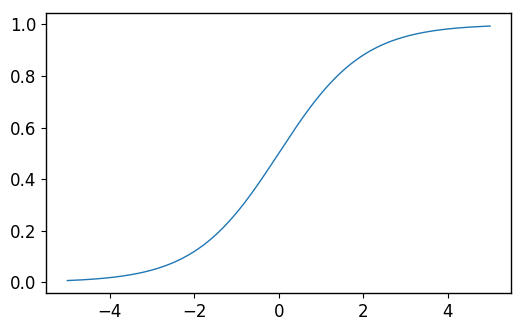

In [38]:
with tf.Session() as sess:
     plt.plot(x.eval(), y.eval())

### Train a CNN in tensorflow

In [89]:
tf.reset_default_graph()

In [90]:
with tf.name_scope('inputs'):
     X = tf.placeholder(dtype=tf.float32, shape=(None, height, width), name="X")
     X_reshaped = tf.reshape(X, shape=(-1, height, width, 1))
     y = tf.placeholder(dtype=tf.int32, shape=(None), name="y")

In [91]:
conv1_fmaps = 20
conv2_fmaps = 40
training = tf.placeholder_with_default(False, shape=(None))

In [92]:
dropout_rate = 0.5
X_drop = tf.layers.dropout(X_reshaped, dropout_rate, training=training)

In [93]:
# https://www.tensorflow.org/versions/master/tutorials/audio_recognition#how_does_this_model_work
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/speech_commands/models.py
conv_1 = tf.layers.conv2d(X_drop, filters=conv1_fmaps, kernel_size=3, strides=[1, 1], padding="SAME", activation=tf.nn.relu)
do_1 = tf.layers.dropout(conv_1, dropout_rate, training=training)
max_pool_1 = tf.nn.max_pool(do_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
conv_2 = tf.layers.conv2d(max_pool_1, filters=conv2_fmaps, kernel_size=2, strides=[2, 2], padding="SAME", activation=tf.nn.relu)
do_2 = tf.layers.dropout(conv_2, dropout_rate, training=training)
max_pool_2 = tf.nn.max_pool(do_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")

with tf.name_scope("fc1"):
     max_pool_2_flat = tf.reshape(max_pool_2, shape=[-1, conv2_fmaps * 16 *  9])
     full_1 = tf.layers.dense(max_pool_2_flat, units=50, activation=tf.nn.relu)

with tf.name_scope("output"):
     prob_positive = tf.layers.dense(full_1, units=1, activation=tf.sigmoid, name='outputs')

In [94]:
with tf.name_scope('loss'):
     loss = tf.losses.log_loss(labels=y, predictions=tf.squeeze(prob_positive))

In [95]:
learning_rate = 0.01
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.95, use_nesterov=True)
training_op = optimizer.minimize(loss)

In [96]:
with tf.name_scope('my_metrics'):
     thres = 0.5
     y_pred = tf.cast(prob_positive > thres, tf.int32)
     cm = tf.confusion_matrix(labels=y, predictions=y_pred, num_classes=2, dtype=tf.float64)
     accuracy = tf.trace(cm) / tf.reduce_sum(cm)

In [97]:
init = tf.global_variables_initializer()

In [98]:
batch_size = 50
n_epochs = 100

In [99]:
with tf.Session() as sess:
     init.run()
     for epoch in xrange(n_epochs + 1):
          for iteration in range(train_paths.size // batch_size):
               X_batch, y_batch = fetch_batch(train_paths, train_labels, batch_size)
               #print max_pool_2.shape
               sess.run(training_op, feed_dict={X:X_batch, y:y_batch, training:True})
          if not (epoch % 10):
               print epoch, "----------"
               print "Accuracy (train):", accuracy.eval(feed_dict={X:X_train, y:y_train})
               print "Accuracy (test):", accuracy.eval(feed_dict={X:X_test, y:y_test})
               print "Loss (train):", loss.eval(feed_dict={X:X_train, y:y_train})
               print "Loss (test):", loss.eval(feed_dict={X:X_test, y:y_test})

0 ----------
Accuracy (train): 0.850750577367
Accuracy (test): 0.838523644752
Loss (train): 0.486716
Loss (test): 0.486409
10 ----------
Accuracy (train): 0.957563510393
Accuracy (test): 0.926182237601
Loss (train): 0.164456
Loss (test): 0.202525
20 ----------
Accuracy (train): 0.971420323326
Accuracy (test): 0.953863898501
Loss (train): 0.118466
Loss (test): 0.159129
30 ----------
Accuracy (train): 0.974595842956
Accuracy (test): 0.943483275663
Loss (train): 0.102518
Loss (test): 0.152815
40 ----------
Accuracy (train): 0.977482678984
Accuracy (test): 0.958477508651
Loss (train): 0.091542
Loss (test): 0.141425
50 ----------
Accuracy (train): 0.983833718245
Accuracy (test): 0.964244521338
Loss (train): 0.0583616
Loss (test): 0.111211
60 ----------
Accuracy (train): 0.981524249423
Accuracy (test): 0.959630911188
Loss (train): 0.0693056
Loss (test): 0.117304
70 ----------
Accuracy (train): 0.974884526559
Accuracy (test): 0.944636678201
Loss (train): 0.0958035
Loss (test): 0.149518
80 ---

### Let's try a simple model based on the sum of values in each spectrogram

In [49]:
X_train, y_train = fetch_batch(train_paths, train_labels, batch_size=train_paths.size)

In [50]:
spectrogram_sum = np.array([spectrogram.sum() for spectrogram in X_train])

In [51]:
np.corrcoef(spectrogram_sum, y_train)

array([[ 1.        ,  0.57153512],
       [ 0.57153512,  1.        ]])

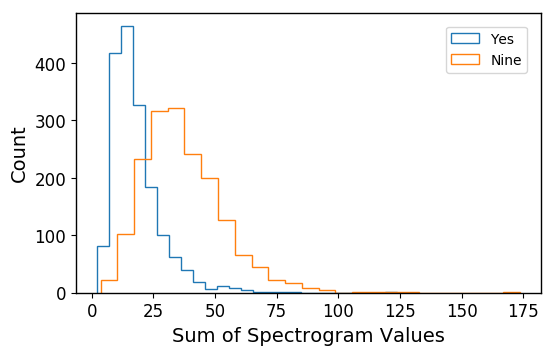

In [52]:
plt.hist(spectrogram_sum[y_train == 0], bins=25, histtype='step', label='Yes')
plt.hist(spectrogram_sum[y_train == 1], bins=25, histtype='step', label='Nine')
plt.legend()
plt.xlabel('Sum of Spectrogram Values')
plt.ylabel('Count')

In [53]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
X = spectrogram_sum.reshape(-1, 1)
print lr.fit(X, y_train).score(X, y_train)

0.792147806005


We see that we achieve 79% accuracy on the train data when the sum of the spectrogram values is used as the only feature.

### Fully connected DNN

Let's try using the same features as the CNN but this time with a fully connected DNN:

In [54]:
tf.reset_default_graph()

In [55]:
training = tf.placeholder_with_default(False, shape=(None))

In [56]:
with tf.name_scope('inputs'):
     X = tf.placeholder(dtype=tf.float32, shape=(None, height, width), name="X")
     X_reshaped = tf.reshape(X, shape=(-1, height * width))
     y = tf.placeholder(dtype=tf.int32, shape=(None), name="y")

Dropout was added since the network was overfitting. It still appears to be overfitting. Logistic regression gives essentially the same score which suggests that a multi-layer DNN cannot be used without more data.

In [57]:
dropout_rate = 0.75
X_drop = tf.layers.dropout(X_reshaped, dropout_rate, training=training)

In [58]:
n_neurons = 25
with tf.name_scope("fc1"):
     fc_1 = tf.layers.dense(X_drop, units=n_neurons, activation=tf.nn.elu)
     do_1 = tf.layers.dropout(fc_1, dropout_rate, training=training)
     #fc_2 = tf.layers.dense(do_1, units=n_neurons, activation=tf.nn.elu)
     #do_2 = tf.layers.dropout(fc_2, dropout_rate, training=training)
     #fc_3 = tf.layers.dense(do_2, units=n_neurons, activation=tf.nn.elu)
     #do_3 = tf.layers.dropout(fc_3, dropout_rate, training=training)
     #fc_4 = tf.layers.dense(do_3, units=n_neurons, activation=tf.nn.elu)
     #do_4 = tf.layers.dropout(fc_4, dropout_rate, training=training)
     prob_positive = tf.layers.dense(do_1, units=1, activation=tf.sigmoid, name='output')

In [59]:
with tf.name_scope('loss'):
     loss = tf.losses.log_loss(labels=y, predictions=tf.squeeze(prob_positive))

In [60]:
learning_rate = 0.01
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9, use_nesterov=True)
training_op = optimizer.minimize(loss)

In [61]:
with tf.name_scope('my_metrics'):
     thres = 0.5
     y_pred = tf.cast(prob_positive > thres, tf.int32)
     cm = tf.confusion_matrix(labels=y, predictions=y_pred, num_classes=2, dtype=tf.float64)
     accuracy = tf.trace(cm) / tf.reduce_sum(cm)

In [62]:
init = tf.global_variables_initializer()

In [63]:
batch_size = 50
n_epochs = 100

In [64]:
with tf.Session() as sess:
     init.run()
     for epoch in xrange(n_epochs + 1):
          for iteration in range(train_paths.size // batch_size):
               X_batch, y_batch = fetch_batch(train_paths, train_labels, batch_size)
               sess.run(training_op, feed_dict={X:X_batch, y:y_batch, training:True})
          if (epoch % 10 == 0):
               print epoch, "----------"
               print "Accuracy (train):", accuracy.eval(feed_dict={X:X_train, y:y_train})
               print "Accuracy (test):", accuracy.eval(feed_dict={X:X_test, y:y_test})
               print "Loss (train):", loss.eval(feed_dict={X:X_train, y:y_train})
               print "Loss (test):", loss.eval(feed_dict={X:X_test, y:y_test})

0 ----------
Accuracy (train): 0.866050808314
Accuracy (test): 0.851211072664
Loss (train): 0.476797
Loss (test): 0.475631
10 ----------
Accuracy (train): 0.923498845266
Accuracy (test): 0.903114186851
Loss (train): 0.215439
Loss (test): 0.234427
20 ----------
Accuracy (train): 0.930715935335
Accuracy (test): 0.911188004614
Loss (train): 0.184212
Loss (test): 0.214648
30 ----------
Accuracy (train): 0.936200923788
Accuracy (test): 0.905420991926
Loss (train): 0.17559
Loss (test): 0.209234
40 ----------
Accuracy (train): 0.937933025404
Accuracy (test): 0.906574394464
Loss (train): 0.166376
Loss (test): 0.206853
50 ----------
Accuracy (train): 0.940531177829
Accuracy (test): 0.913494809689
Loss (train): 0.158643
Loss (test): 0.203325
60 ----------
Accuracy (train): 0.94370669746
Accuracy (test): 0.911188004614
Loss (train): 0.15236
Loss (test): 0.197532
70 ----------
Accuracy (train): 0.945150115473
Accuracy (test): 0.908881199539
Loss (train): 0.149236
Loss (test): 0.199618
80 ---------

### Logistic regression applied to flattened image data

In [65]:
param_grid = [{'C':np.logspace(-1, 1, num=10, base=10.0)}]

In [66]:
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(penalty='l2', class_weight='balanced')
gs = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', refit=True)
gs = gs.fit(X_train.reshape(-1, height * width), y_train)
gs.score(X_test.reshape(-1, height * width), y_test)

0.89850057670126871

In [67]:
gs.best_params_

{'C': 0.27825594022071243}

# Conclusions

The table below shows the model performance. As expected the CNN outperformed the others.

| Model | Accuracy   |
|------|------|
|   Sum spectrogram  | 79%|
|   Logistic Reg.  | 90%|
|   DNN  | 91%|
|   CNN  | 96%|